In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

In [2]:
data_SA = pd.read_csv('C:\\Users\\zollner\\OneDrive - epfl.ch\\Documents\\SGR TZ\\Quadrant\\Quadrant - Location Data Sample_South Africa_10,000 rows.csv')

# Data Completeness and Noise

Missing values per column: device_id                 0
id_type                   0
latitude                  0
longitude                 0
horizontal_accuracy       0
timestamp                 0
ip_address             7258
device_os                 0
os_version             7798
user_agent             7664
country                   0
source_id                 0
publisher_id              0
app_id                 9991
location_context       9890
geohash                   0
consent                   0
quad_id                   0
dtype: int64
Number of duplicate pings: 141


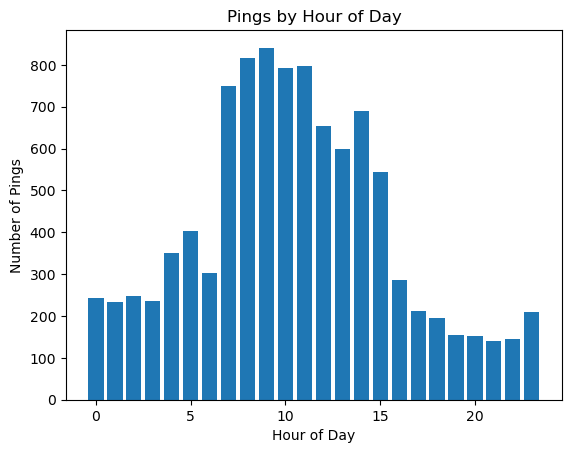

In [4]:

# Missing values: Count missing lat/long, timestamps, or user IDs.
missing_values = data_SA.isnull().sum()
print("Missing values per column:", missing_values)

# Duplicates: Identify duplicate pings or overlapping records.
duplicates = data_SA[["latitude", "longitude"]].duplicated().sum()
print("Number of duplicate pings:", duplicates)
duplicate_rows = data_SA[data_SA[["latitude", "longitude"]].duplicated(keep=False)]

# Battery or app bias: Some datasets show clustering around times when users have internet/battery.
data_SA['timestamp'] = pd.to_datetime(data_SA['timestamp'], unit='ms', utc=True)
data_SA['hour'] = data_SA['timestamp'].dt.hour
hourly_counts = data_SA['hour'].value_counts().sort_index()
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pings')
plt.title('Pings by Hour of Day')
plt.show()


# Sample composition 

In [6]:

# Number of unique users: How many unique device IDs are there?
unique_users = data['device_id'].nunique()
print("Number of unique users:", unique_users)

# How long do users stay active in the dataset? (e.g. some might appear only once).
data['date'] = data['timestamp'].dt.date
user_persistence = data.groupby('device_id')['date'].nunique()
print("User persistence (number of active days):")
print(user_persistence.describe())

Number of unique users: 7484
User persistence (number of active days):
count    7484.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: date, dtype: float64


# Spatial Coverage

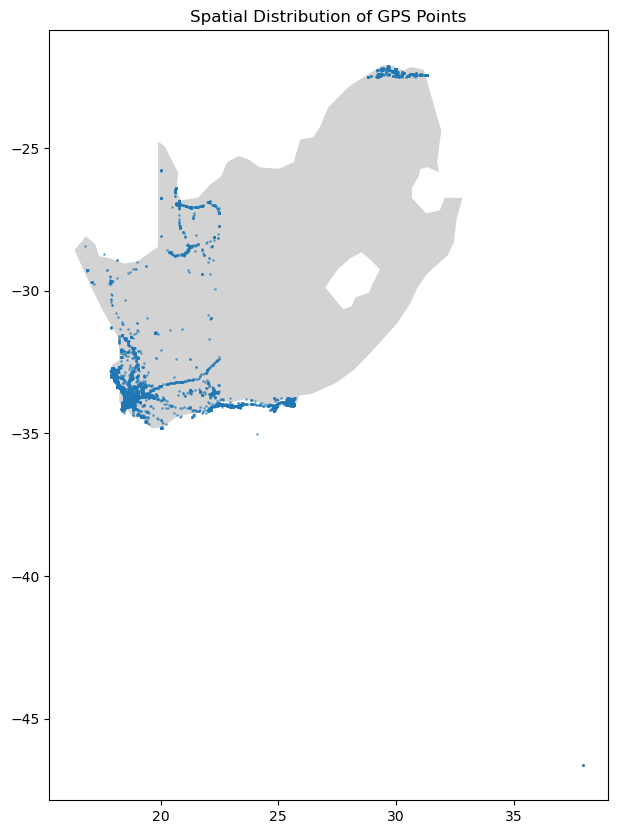

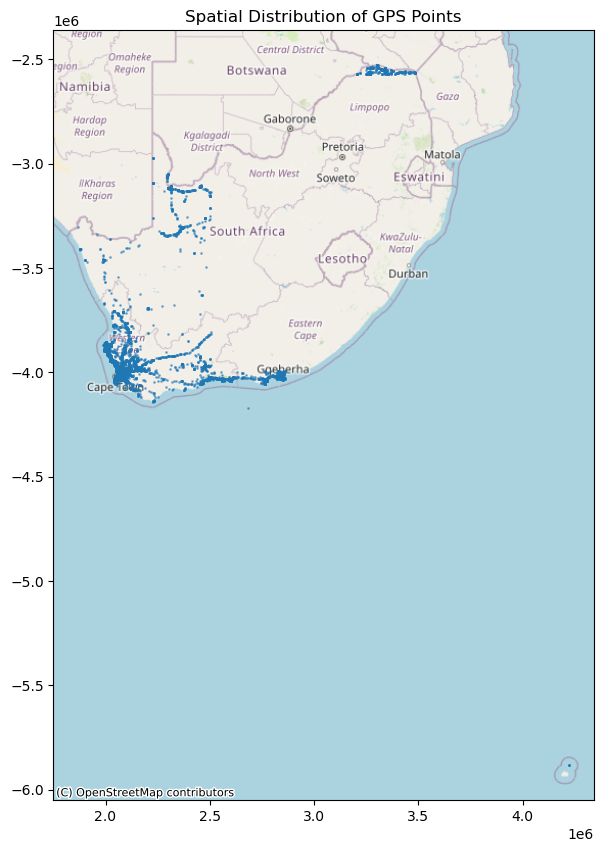

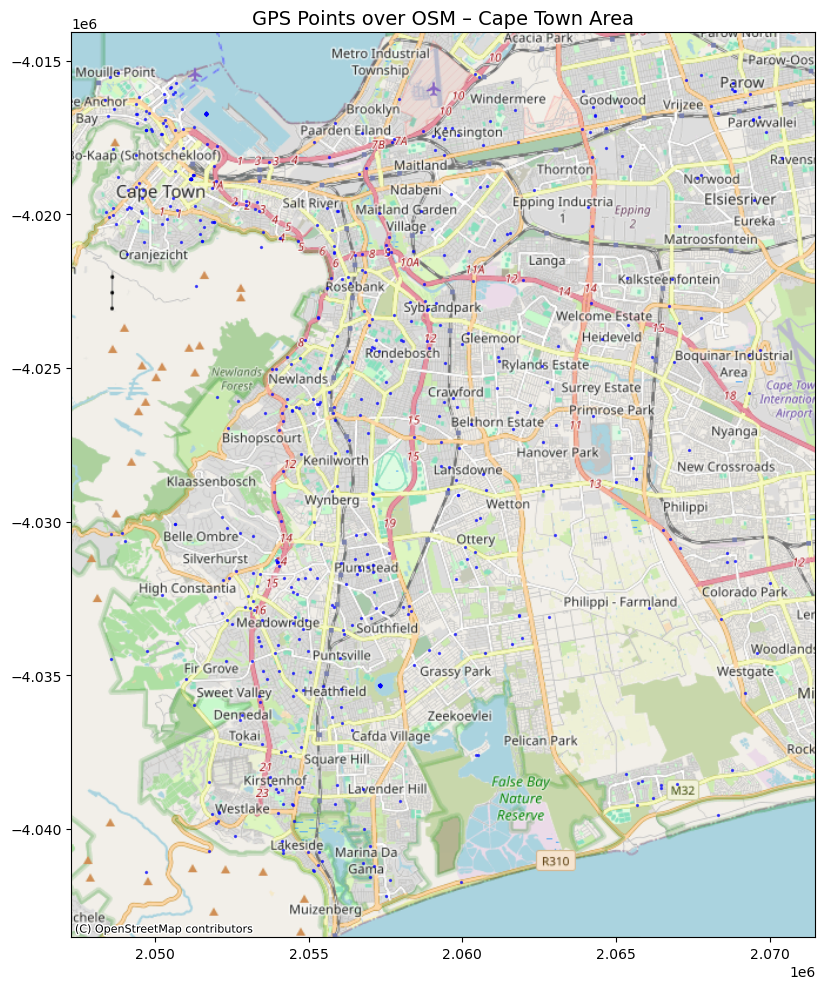

Longitude decimal places stats:
count    10000.000000
mean         5.964600
std          0.742968
min          1.000000
25%          6.000000
50%          6.000000
75%          6.000000
max          8.000000
Name: lon_decimal_places, dtype: float64
Latitude decimal places stats:
count    10000.000000
mean         5.926800
std          0.793665
min          1.000000
25%          6.000000
50%          6.000000
75%          6.000000
max          8.000000
Name: lat_decimal_places, dtype: float64


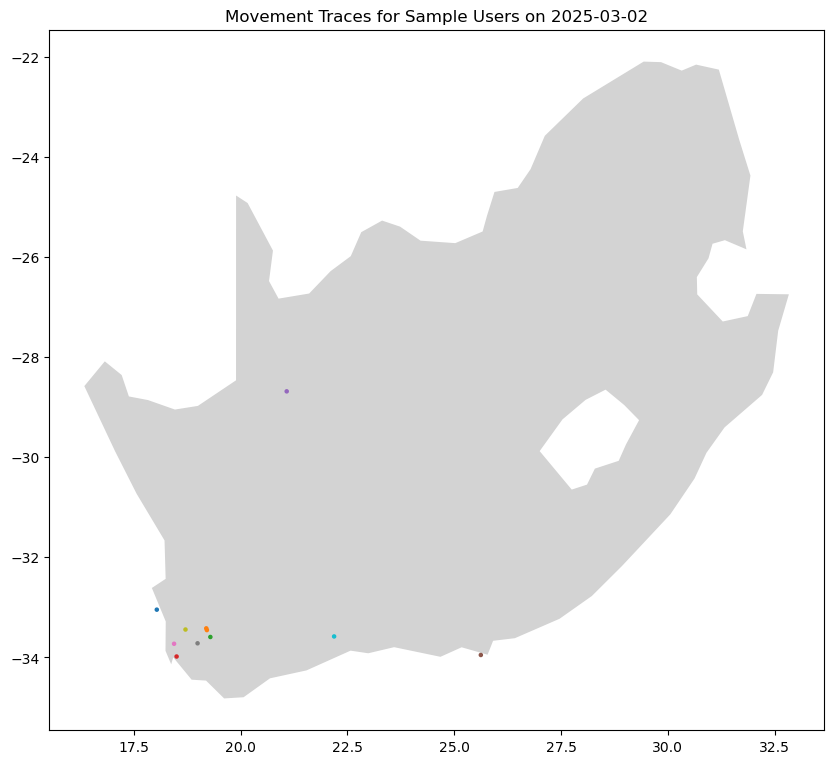

In [17]:
# Coverage: Verify that points cover the study area (e.g. around the SGR corridor, stations, and comparison areas). Are both treatment and control zones well-represented?
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs="EPSG:4326")
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
SA = world[world['ADMIN'] == 'South Africa']

fig, ax = plt.subplots(figsize=(10, 10))
SA.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=1, alpha=0.5)
plt.title('Spatial Distribution of GPS Points')
plt.show()

subset = gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
subset.plot(ax=ax, markersize=1, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Spatial Distribution of GPS Points')
plt.show()

# Spatial accuracy: Are points snapped to realistic locations (roads, urban centers, etc.)?
subset = gdf.cx[18.4:18.6, -34.1:-33.9].to_crs(epsg=3857) # subset to a smaller bounding box (Cape Town) 
fig, ax = plt.subplots(figsize=(10, 10))
subset.plot(ax=ax, markersize=2, alpha=0.6, color='blue')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("GPS Points over OSM – Cape Town Area", fontsize=14)
plt.tight_layout()
plt.show()

# Spatial resolution: Check the precision of coordinates (number of decimal places). You need ~5 decimal digits (~1 m accuracy) for reliable trip-level analysis.
gdf['lon_decimal_places'] = gdf['longitude'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
gdf['lat_decimal_places'] = gdf['latitude'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
print("Longitude decimal places stats:")
print(gdf['lon_decimal_places'].describe())
print("Latitude decimal places stats:")
print(gdf['lat_decimal_places'].describe())

# Quick test: Map 1 day of data for 5–10 users — does the movement trace align with real roads and stations?
 # --> Ideally I would plot movement traces here, but for most users I only have one point in the dataset
 
sample_date = data['date'].iloc[0]
sample_users = data['device_id'].drop_duplicates().sample(10, random_state=1).values
sample_data = data[(data['date'] == sample_date) & (data['device_id'].isin(sample_users))]
sample_gdf = gpd.GeoDataFrame(sample_data, geometry=gpd.points_from_xy(sample_data.longitude, sample_data.latitude), crs="EPSG:4326")
fig, ax = plt.subplots(figsize=(10, 10))
SA.plot(ax=ax, color='lightgrey')
sample_gdf.plot(ax=ax, column='device_id', legend=False, markersize=5)
plt.title(f'Movement Traces for Sample Users on {sample_date}')
plt.show()



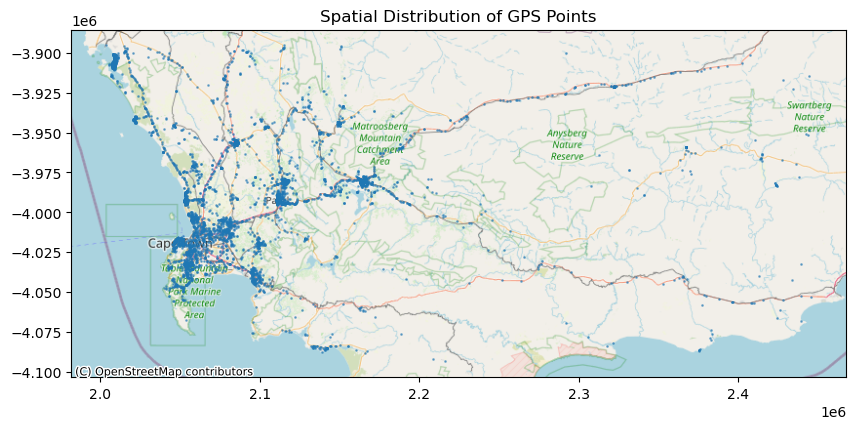

In [19]:
#subset = gdf.to_crs(epsg=3857)
subset = gdf.cx[18:22, -34.5:-33].to_crs(epsg=3857) # subset to a smaller bounding box (Cape Town) 
fig, ax = plt.subplots(figsize=(10, 10))
subset.plot(ax=ax, markersize=1, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Spatial Distribution of GPS Points')
plt.show()


# Temporal Coverage

Ping frequency statistics (seconds):
count    9999.000000
mean        8.637864
std        11.977832
min         0.000000
25%         2.000000
50%         5.000000
75%        11.000000
max       182.000000
Name: timestamp, dtype: float64
Ping frequency statistics per user (seconds):
count     2516.000000
mean      8828.943561
std      12625.799967
min          0.000000
25%        369.750000
50%       3503.000000
75%      12312.250000
max      85051.000000
Name: timestamp, dtype: float64
Average pings per user: 1.3361838588989845
Number of long gaps (30 min): 0
Number of long gaps (30 min): 1502


Text(0.5, 0, 'Time Interval Between Pings (minutes)')

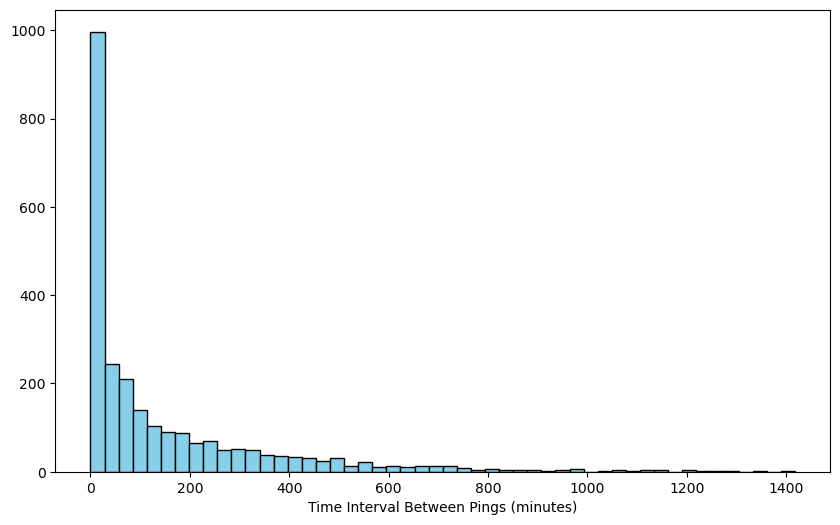

In [40]:

# Over how many months/years does the data span? --> This does not apply for the sample, would need to make sure for purchased data

# Granularity: How frequent are GPS pings?
frequency = data['timestamp'].sort_values().diff().dt.total_seconds().dropna()
print("Ping frequency statistics (seconds):")
print(frequency.describe())

frequency_per_user = data.groupby('device_id')['timestamp'].apply(lambda x: x.sort_values().diff().dt.total_seconds().dropna())
print("Ping frequency statistics per user (seconds):")
print(frequency_per_user.describe())

# How many pings per user are there on average?
avg_pings_per_user = data.groupby('device_id').size().mean()
print(f'Average pings per user: {avg_pings_per_user}')

# Consistency: Are timestamps regular? Are there long gaps (e.g., missing nights or weekends)?
gaps = frequency[frequency > 60 * 30]  # gaps longer than 30 minutes
print(f"Number of long gaps (30 min): {gaps.count()}")

gaps = frequency_per_user[frequency_per_user > 60 * 30]  # gaps longer than 30 minutes
print(f"Number of long gaps (30 min): {gaps.count()}")

# Quick test: Plot time intervals between consecutive pings per user to detect irregular sampling.
plt.figure(figsize=(10, 6))
plt.hist(frequency_per_user / 60, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Time Interval Between Pings (minutes)') 

# Trip Reconstruction and Mode Detection

In [ ]:
# Trip inference: Can you reliably detect trips (vs stationary periods)? Check if the GPS density allows segmentation into trips. - Not in this sample

# If mode is not provided, can you infer mode from speed/distance? - Not in this sample

# Speed sanity checks: Compute speeds between consecutive points; unrealistic speeds (>200 km/h) often indicate errors. - Not in this sample

# Findings

I need multiple pings per user per day. For comparison, in Blanchard et al. they only use people who show up for 10 nights and 50% in the same spot over night, and for  8 distinct weekdays at work and 50% of total weekdays at the same spot. 

For Tanzania, they have 237,123 (22,994) (high-confidence) users with 457 (2,132) pings over one entire year. For the big sample, they have a bit more than 1 ping per day (similar to this sample where I have 1.3 pings per user). In the high confidence sample, they have around 6 pings per day. - None of this would be enough to plot trajectories/transport mode/speed etc. 

# What do I need the data for? 

- Comparison of mobility patterns before/after -> e.g. frequency, spatial extent, densities, specific locations visited
--> Do I think the SGR has impacted these "longer visits" ? Since I will likely not see within day travel
--> less people at airports and busstations, more at trainstations?
- More research on "consumption trips" and how they are influenced by better transport connections?